# Classification Model

In [1]:
# importing libraries
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree# tree plots
from sklearn.ensemble import RandomForestClassifier #Random Forest model
from sklearn.ensemble import GradientBoostingClassifier # GBM model

# loading data

file = "./dataset/Cross_Sell_Success_Dataset_2023.xlsx"

cssd = pd.read_excel(io = file)

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


# displaying the head of the dataset
cssd.head(n = 5)

,CROSS_SELL_SUCCESS,EMAIL,REVENUE,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,CANCELLATIONS_AFTER_NOON,PC_LOGINS,MOBILE_LOGINS,WEEKLY_PLAN,LATE_DELIVERIES,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,AVG_MEAN_RATING,TOTAL_PHOTOS_VIEWED
0,1,steffon.baratheon@yahoo.com,4920.0,493,9,1,10,265.6,5,5,2,0,0,137.41,6,2.894737,456
1,0,harlon.greyjoy@visa.com,6150.0,361,9,1,6,247.0,2,5,1,0,0,120.20,5,2.631579,680
2,0,monster@protonmail.com,3435.0,278,6,1,4,164.4,0,6,1,5,0,127.00,3,3.684211,145
3,1,damon.lannister.(lord)@yahoo.com,3330.0,269,8,1,2,176.0,5,5,2,0,0,129.78,6,3.157895,418
4,1,raynald.westerling@jnj.com,3427.5,276,7,1,10,164.6,0,6,1,14,0,34.42,3,3.157895,174


## User-defined functions

In the following section, we will create several custom functions that will aid our analysis.

In [2]:
########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # bulding heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

    
#distribution function to anaylyse variable distribution
def distributions(variable, data, bins = 'fd', kde = False, rug = False):
    """
    This function can be used for continuous or count variables.

    PARAMETERS
    ----------
    variable : str, continuous or count variable
    data     : DataFrame
    bins     : argument for matplotlib hist(), optional. If unspecified, Freedman–Diaconis rule is used.
    kde      : bool, optional, plot or not a kernel density estimate.  If unspecified, not calculated.
    rug      : bool, optional, include a rug on plot or not. If unspecified, not shown.
    """
    
    sns.distplot(data[variable],  
                    bins  = bins,
                    kde   = False,
                    rug   = rug)
    
    plt.xlabel(variable)
    plt.tight_layout()
    plt.show()

In [ ]:
#checking if there is missing value
cssd.isnull().any().any()

No missing value in our dataset

In [ ]:
# storing data dictionary
cssd_description = pd.read_excel('./dataset/Apprentice_Chef_Data_Dictionary.xlsx')


# data dictionary
cssd_description

Since our target variable is binary, it is crucial to ensure that the number of successful and unsuccessful outcomes is balanced in our sample to avoid any bias in our analysis.

In [4]:
cssd['CROSS_SELL_SUCCESS'].value_counts()

1    1321
0     625
Name: CROSS_SELL_SUCCESS, dtype: int64

Our response variable sample size is large enough.
To guarantee that our model has equal representation of successful and unsuccessful outcomes in both training and testing, we will employ stratification methods when splitting the dataset.

In [5]:
# Analysis of Cancellations After Noon feature
# count of cancellations after noon that subscribe to new service
check = cssd.loc[:,'CANCELLATIONS_AFTER_NOON'][cssd.loc[:,'CROSS_SELL_SUCCESS'] == 1]\
                                                     [cssd.loc[:,'CANCELLATIONS_AFTER_NOON'] > 0]

# count of cancellations after noon that did not subscribe to new service
check2 = cssd.loc[:,'CANCELLATIONS_AFTER_NOON'][cssd.loc[:,'CROSS_SELL_SUCCESS'] == 0]\
                                                   [cssd.loc[:,'CANCELLATIONS_AFTER_NOON'] > 0]
print('count of cancellation that subscribe:', len(check))
print('count of cancellation that did not subscribe:', len(check2))

count of cancellation that subscribe: 974
count of cancellation that did not subscribe: 400


In [6]:
(974)/(400+974)

0.7088791848617176

This implies that 71% of individuals who cancel their order after noon opt for the promotion.

We can conclude that cancellation after noon might be a beneficial feature in developing our model based on the observation that 71% of consumers who cancel their order after noon subscribe to the offer. Adding this feature to our model might increase its accuracy in predicting new subscribers.

## Feature Engineering 

When promoting Halfway There to a wider consumer base, several promotion strategies such as sales email might be considered. By checking the clients' email domains provided throughout the application process, we can tell whether they are using personal, professional, or 'junk' emails.

We can assess whether clients who use personal or business emails are more likely to buy the subscription by include these elements in our study. We can use this information to help us implement an email marketing campaign for these clients. Also, if we notice potential clients receiving "junk" emails, it would be necessary to start a campaign on a separate platform.

We can assess whether clients who use personal or business emails are more likely to buy the subscription by include these elements in our study. We can use this information to help us implement an email marketing campaign for these clients.

The customer's email domain will be extracted, their emails will be divided into "personal," "professional," and "junk" categories, and a new category variable will be created. Next, we'll apply one-hot encoding to this variable to create three additional columns, one for each type of email. If the matching email category matches, an observation in these columns will have the value 1.


In [7]:
# STEP 1: splitting personal emails

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in cssd.iterrows():
    
    # splitting email domain at '@'
    split_email = cssd.loc[index,'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)


# displaying the results
email_df



,0,1
0,steffon.baratheon,yahoo.com
1,harlon.greyjoy,visa.com
2,monster,protonmail.com
3,damon.lannister.(lord),yahoo.com
4,raynald.westerling,jnj.com
...,...,...
1941,wat.(barleycorn),live.com
1942,hendry.bracken,exxon.com
1943,aenys.i.targaryen,passport.com
1944,leo.blackbar,pg.com


In [8]:
# STEP 2: concatenating with original DataFrame

# making multiple concatenations


# renaming column to concatenate
email_df.columns = ['0' ,'type_email_domain']


# concatenating email_domain with apprentice DataFrame
cssd = pd.concat([cssd, email_df['type_email_domain']],
                        axis = 1)


# printing value counts for each email_domain
cssd.loc[: ,'type_email_domain'].value_counts()

# clasifying the email domain types between professional, personal and junk:
Professional_email_domains  = ['@mmm.com','@amex.com','@apple.com','@boeing.com',
                               '@caterpillar.com','@chevron.com','@cisco.com','@cocacola.com',
                               '@disney.com','@dupont.com','@exxon.com','@ge.org','@goldmansacs.com',
                               '@homedepot.com','@ibm.com','@intel.com','@jnj.com','@jpmorgan.com',
                               '@mcdonalds.com','@merck.com','@microsoft.com','@nike.com','@pfizer.com',
                               '@pg.com','@travelers.com','@unitedtech.com','@unitedhealth.com',
                               '@verizon.com','@visa.com','@walmart.com']

personal_email_domains      = ['@gmail.com','@yahoo.com','@protonmail.com']

Junk                        = ['@me.com','@aol.com','@hotmail.com','@live.com','@msn.com','@passport.com']

# creating the list for professional, personal and junk:
# placeholder list
placeholder_lst = []


# looping to group observations by domain type
for domain in cssd['type_email_domain']:        

    if '@' + domain in Professional_email_domains:
        placeholder_lst.append('Professional')
        
    elif '@' + domain in personal_email_domains:
        placeholder_lst.append('Personal')
 
    elif '@' + domain in Junk:
        placeholder_lst.append('Junk')

    else:
        print('unknown')


# concatenating new list with original DataFrame
cssd['domain_group'] = pd.Series(placeholder_lst)


# checking results 
cssd['domain_group'].value_counts()


# one hot encoding categorical variables
one_EMAIL    = pd.get_dummies(cssd['domain_group'])

# dropping categorical variables after they've been encoded
cssd = cssd.drop('domain_group', axis = 1) # dropping even though not encoded


# joining codings together
cssd = cssd.join([one_EMAIL])


# saving new columns in the database
new_columns = cssd.columns

In [9]:
cssd['TOTAL_LOGINS'] = cssd['PC_LOGINS'] + cssd['MOBILE_LOGINS']

We will make graphs for both interval and continuous variables to better understand the distribution of our data and spot any outliers. These graphs will help us see how the data is distributed and look for any trends or irregularities. We can learn about possible flaws or problems with the data and understand how these outliers might affect our study by recognizing them and their distribution. 

An important stage in guaranteeing the precision and dependability of our findings is the process of charting and evaluating the distribution of our data. We can decide how to move on with our analysis and deal with any potential problems if we have a clear grasp of how our data are distributed.

C:\Users\Kevin Kabore\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


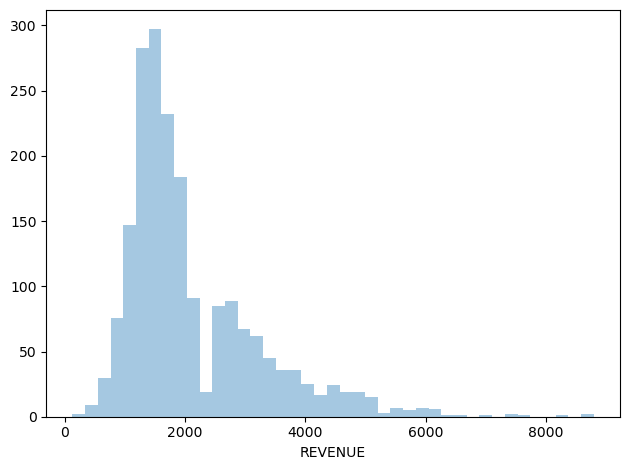

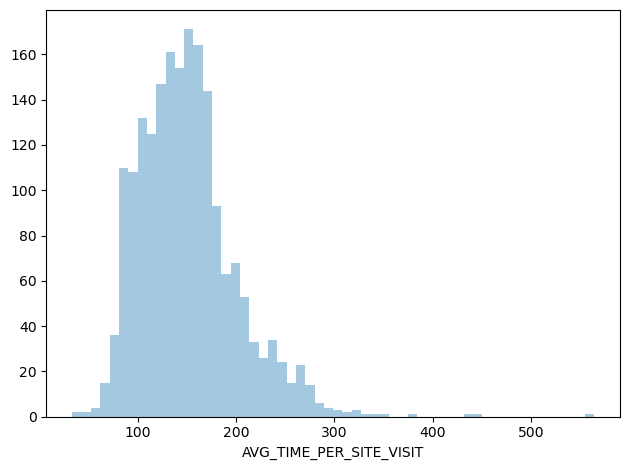

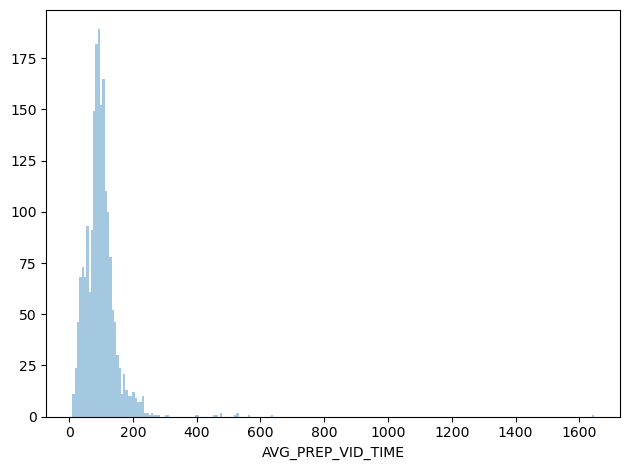

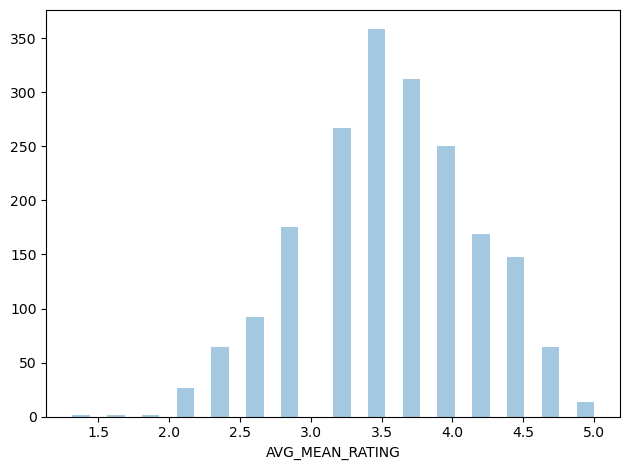

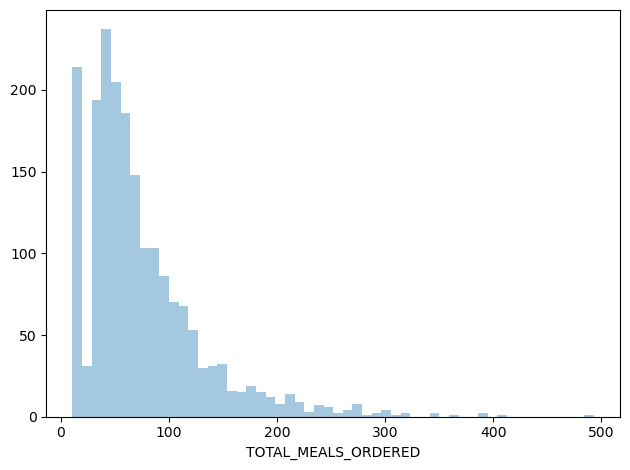

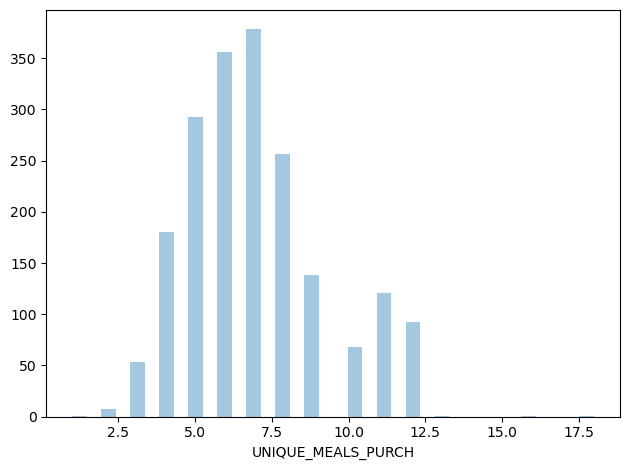

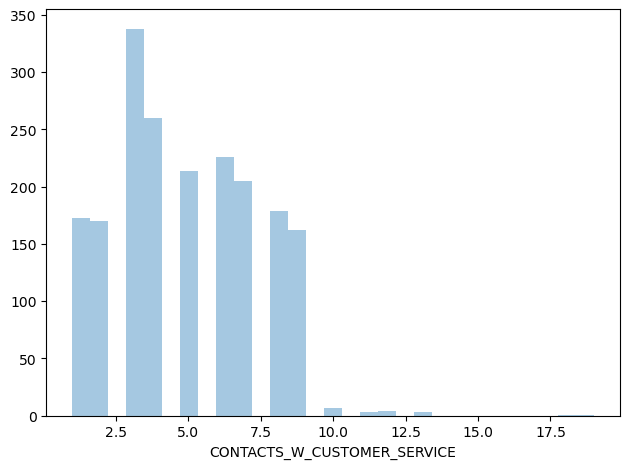

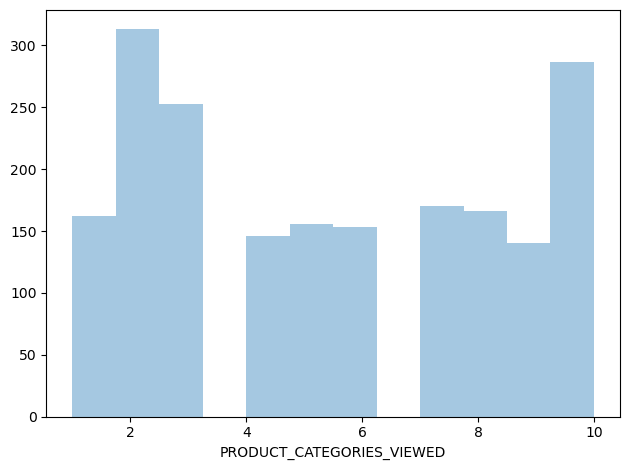

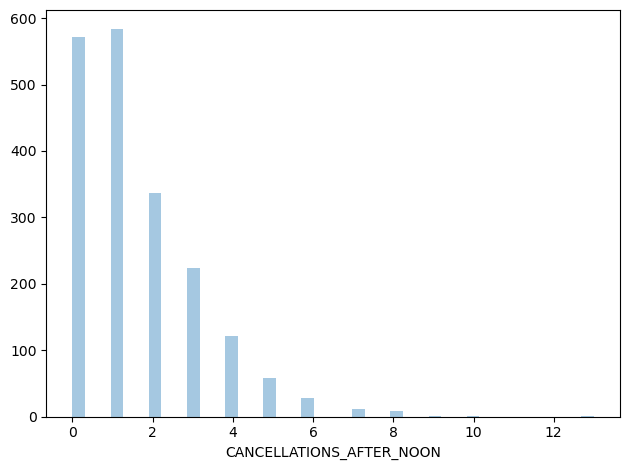

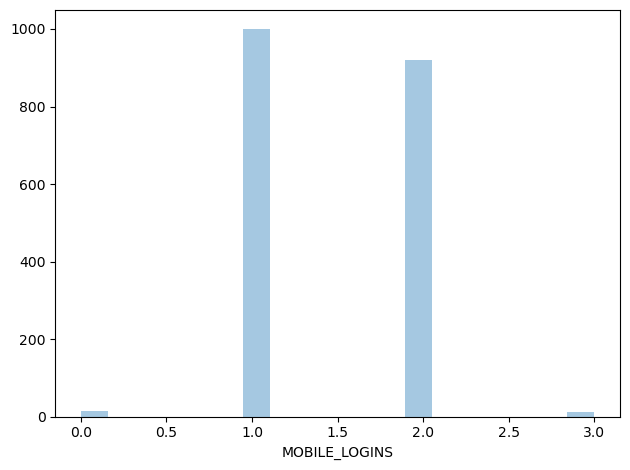

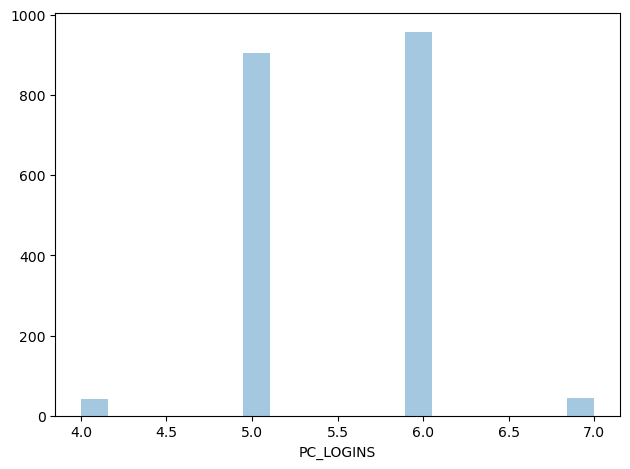

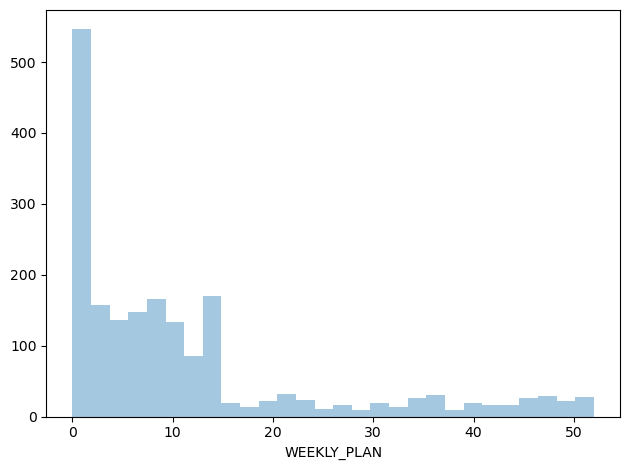

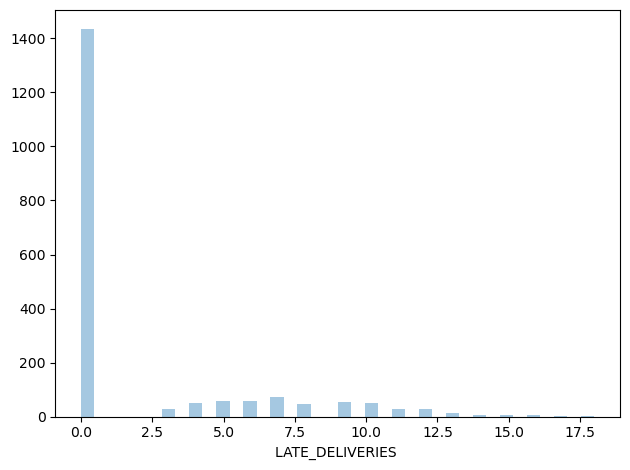

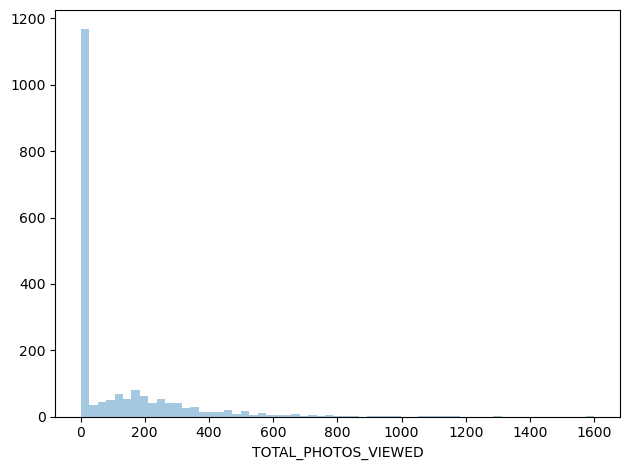

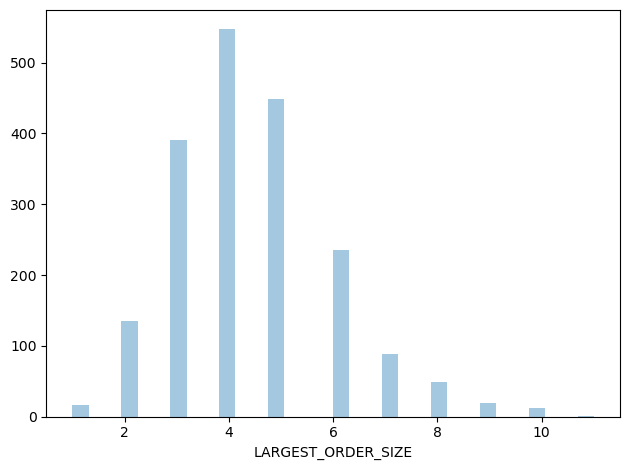

In [10]:
for variable in continuous + interval:
    distributions(variable, cssd, bins = 'fd', kde = True, rug = False)

## Correlation

In [11]:
#building correlation of my 
cssd_corr = cssd.corr().round(2)

cssd_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

CROSS_SELL_SUCCESS             1.00
Professional                   0.19
CANCELLATIONS_AFTER_NOON       0.14
TOTAL_LOGINS                   0.07
MOBILE_LOGINS                  0.06
UNIQUE_MEALS_PURCH             0.04
PC_LOGINS                      0.04
Personal                       0.04
AVG_TIME_PER_SITE_VISIT        0.03
LATE_DELIVERIES                0.02
LARGEST_ORDER_SIZE             0.02
AVG_PREP_VID_TIME              0.01
TOTAL_PHOTOS_VIEWED            0.01
TOTAL_MEALS_ORDERED            0.01
CONTACTS_W_CUSTOMER_SERVICE   -0.00
PRODUCT_CATEGORIES_VIEWED      0.00
REVENUE                        0.00
WEEKLY_PLAN                   -0.01
AVG_MEAN_RATING               -0.04
Junk                          -0.28
Name: CROSS_SELL_SUCCESS, dtype: float64

We can observe from the correlation coefficients that a number of variables positively correlate with CROSS SELL SUCCESS. These variables are Personal (0.04), Unique Meals Purch (0.04), PC Logins (0.04), Professional (0.19), Cancelations After Noon (0.14), Mobile Logins (0.06), and AVG TIME PER SITE VISIT (0.04). (0.03).

On the other side, a few factors, including AVG MEAN RATING (-0.04), WEEKLY PLAN (-0.01), and CONTACTS W CUSTOMER SERVICE (-0.02), had a negative link with CROSS SELL SUCCESS (-0.00).

It is significant to note that there is a negative (-0.28) connection between the variable "Junk" and "CROSS SELL SUCCESS," suggesting that customers who use "junk" email addresses are less likely to sign up for the campaign. This can be the result of these clients' lower email engagement or general disinterest in promotional offers.

In [12]:
cssd.loc[ : ,'CROSS_SELL_SUCCESS'].value_counts(normalize = True).round(decimals = 2)

1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64

In [14]:
# declaring explanatory variables
cssd_data1 = cssd.drop('CROSS_SELL_SUCCESS', axis = 1)


# declaring response variable
cssd_target = cssd.loc[ : , 'CROSS_SELL_SUCCESS']

In [15]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            cssd_data1,
            cssd_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = cssd_target) # preserving balance


# merging training data for statsmodels
cssd_train = pd.concat([x_train, y_train], axis = 1)

In [16]:
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")



Response Variable Proportions (Training Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64



In [17]:
#  logistic regression model variable selection
logistic_small = smf.logit(formula = """CROSS_SELL_SUCCESS ~  UNIQUE_MEALS_PURCH +                                                       
                                                             CANCELLATIONS_AFTER_NOON +                                                        
                                                             Professional +
                                                             Junk + 
                                                            MOBILE_LOGINS                                                           
                                                            """, data    = cssd_train)


# fitting our model
results_logistic = logistic_small.fit()


# display the result summary
results_logistic.summary2() # summary2() has AIC and BIC

Optimization terminated successfully.
         Current function value: 0.571774
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                 Logit               Pseudo R-squared:  0.089     
Dependent Variable:    CROSS_SELL_SUCCESS  AIC:               1680.4354 
Date:                  2023-03-03 17:34    BIC:               1712.1485 
No. Observations:      1459                Log-Likelihood:    -834.22   
Df Model:              5                   LL-Null:           -916.19   
Df Residuals:          1453                LLR p-value:       1.4230e-33
Converged:             1.0000              Scale:             1.0000    
No. Iterations:        5.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept                -0.3250   0.2640 -1.2311 0.2183 -0.8425  0.1924
UNIQUE_MEALS_PURCH        0.0541   0.0261  2.0765 0.0378  0.0030  0.1052
CANCELLATIONS_AFTER_NOON  0.2140   0.0409  5.2291 0.0000  0.1338  0.2943
Professional              0.4580   0.1396  3.2806 0.0010  0.1844  0.7316
Junk                     -1.2612   0.1508 -8.3636 0.0000 -1.5568 -0.9657
MOBILE_LOGINS             0.3517   0.1133  3.1037 0.0019  0.1296  0.5738
========================================================================

"""

In [18]:
# explanatory sets from last session

# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : ['REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE',
                   'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 
                   'CANCELLATIONS_AFTER_NOON', 'PC_LOGINS', 'MOBILE_LOGINS',
                   'WEEKLY_PLAN', 'LATE_DELIVERIES', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE',
                   'AVG_MEAN_RATING', 'TOTAL_PHOTOS_VIEWED' ],
 

 # logit sig variable with p value < 0.05
 'logit_sig'    : ['UNIQUE_MEALS_PURCH', 'CANCELLATIONS_AFTER_NOON', 'MOBILE_LOGINS', 'Junk', 'Professional']
    
}

Based on the findings of a logistic regression model, which excludes variables with high p-values, the significant variables are chosen. In this example, the outcome variable is "CROSS SELL SUCCESS," and these factors are thought to be less important to the model and maybe to prediction.

As a result, the 'logit_sig' model, which only takes into account the most important factors, might be a more efficient model for predicting 'CROSS SELL SUCCESS'.

In [19]:
# printing candidate variable sets
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict['logit_full']}


First Significant p-value Model:
--------------------------------
{candidate_dict['logit_sig']}

""")


/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 'CANCELLATIONS_AFTER_NOON', 'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 'LATE_DELIVERIES', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'AVG_MEAN_RATING', 'TOTAL_PHOTOS_VIEWED']


First Significant p-value Model:
--------------------------------
['UNIQUE_MEALS_PURCH', 'CANCELLATIONS_AFTER_NOON', 'MOBILE_LOGINS', 'Junk', 'Professional']




## Building models

### Logistic Regression

In [45]:
# train/test split with the full model
cssd_data   =  cssd.loc[ : , candidate_dict['logit_sig']]
cssd_target =  cssd.loc[ : , 'CROSS_SELL_SUCCESS']


# this is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            cssd_data,
            cssd_target,
            random_state = 219,
            test_size    = 0.25,
           stratify     = cssd_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)

# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()



# printing confusion matrix
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")

# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

# printing the results
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))
print('AUC SCORE:', logreg_auc_score)


# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy



# displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)


True Negatives : 53
False Positives: 103
False Negatives: 32
True Positives : 299

LogReg Training ACCURACY: 0.7265
LogReg Testing  ACCURACY: 0.7228
AUC SCORE: 0.6215
LogReg Train-Test Gap   : 0.0037


The significant variables from the dataset were used to train and test the logistic regression model. The model's accuracy score on the test data was 72.28%, which shows that it can accurately predict the value of the target variable.

The 32 false negatives and 103 false positives predicted during testing show that the model's performance is imperfect. False negatives are situations where a client actually subscribed to the promotion despite the model's prediction that they wouldn't. False positives, on the other side, describe situations where a consumer was expected to subscribe but ultimately did not.

### Decision Tree Classifier

In [ ]:
help(DecisionTreeClassifier)

In [43]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier( min_samples_split = 10, min_samples_leaf = 50, random_state = 219)


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)




# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy
full_tree_gap = abs(full_tree_train_score - full_tree_test_score).round(4)


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc


# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing confusion matrix
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


# printing the model result
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))
print('Full Tree Gap:', full_tree_gap )

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


True Negatives : 53
False Positives: 103
False Negatives: 32
True Positives : 299

Full Tree Training ACCURACY: 0.7252
Full Tree Testing ACCURACY : 0.7207
Full Tree Gap: 0.0045
Full Tree AUC Score: 0.6336


The accuracy of the model on the training data is 0.7252, which means that the model correctly predicted the outcome for 72.52% of the training cases. The accuracy of the model on the testing data is 0.7207, which means that the model correctly predicted the outcome for 72.07% of the testing cases. There is a small gap of 0.0045 between the training and testing accuracies, which indicates that the model is not overfitting or underfitting.

In [30]:
from sklearn.model_selection import RandomizedSearchCV # hyperparameter tuning
# declaring a hyperparameter space
criterion_range = ["gini", "entropy"]
splitter_range  = ["best", "random"]
depth_range     = np.arange(1, 9, 1)
min_samples_leaf    = np.arange(1, 1000, 1)
max_features = ["auto", "sqrt", "log2"]


# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_range,
              'splitter'         : splitter_range,
              'max_depth'        : depth_range,
              'min_samples_leaf' : min_samples_leaf,
              'max_features': max_features
             }


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)


# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 5,
                                   n_iter                = 1000,
                                   random_state          = 219,
                                   scoring = 'roc_auc')


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(cssd_data, cssd_target)


# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

Tuned Parameters  : {'splitter': 'best', 'min_samples_leaf': 100, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy'}
Tuned Training AUC: 0.6822


In [49]:
# INSTANTIATING a classification tree object
full_tree = tuned_tree_cv.best_params_

# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)




# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy
full_tree_gap = abs(full_tree_train_score - full_tree_test_score).round(4)


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc


# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()

print("""FINAL MODEL""")
# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))
print('Full Tree Gap:', full_tree_gap )

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


FINAL MODEL

True Negatives : 53
False Positives: 103
False Negatives: 32
True Positives : 299

Full Tree Training ACCURACY: 0.7252
Full Tree Testing ACCURACY : 0.7207
Full Tree Gap: 0.0045
Full Tree AUC Score: 0.6336


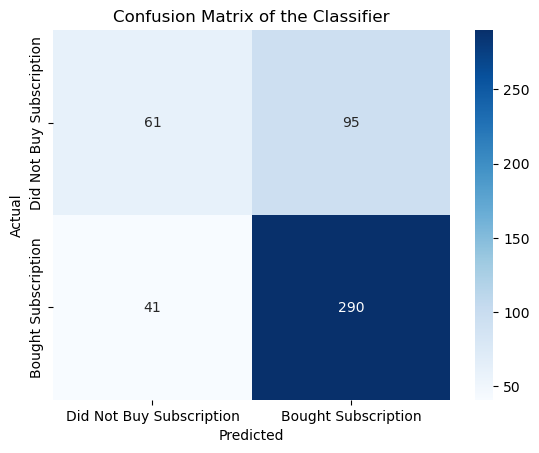

In [47]:
visual_cm(true_y = y_test,
          pred_y = full_tree_pred,
          labels = ['Did Not Buy Subscription', 'Bought Subscription'])

The final model is a decision tree classifier that has been optimized to identify which clients are most likely to take advantage of the promotion and purchase wine. The model has been tested on fresh data after being trained on old customer data.

According to the evaluation findings, the final model is 72.07% accurate overall on the testing set, which means that it accurately predicts the outcome for 72.07% of the users. The training set's accuracy is marginally higher, at 0.7252, proving that the model hasn't overfit the training set's data. The training and testing accuracies only differ by 0.0045, which indicates that the model is performing consistently on both sets of data.

The model's AUC score, a well-liked performance statistic for binary classification models, assesses how well it can distinguish between positive and negative classes. The final model's AUC score is 0.6336, meaning it does a marginally better job of differentiating between clients who are more likely to accept the deal and purchase wine and those who are less likely to do so.

According to the confusion matrix, the final model had 290 true positives, 95 false positives, 61 true negatives, and 41 false negatives. The number of customers who were correctly identified as being likely to accept the promotion and purchase wine is represented by the true positives, while the number of customers who were incorrectly identified as being likely to do so is represented by the false positives. The number of customers who were accurately identified as being unlikely to accept the promotion and purchase wine is represented by the true negatives, whilst the number of customers who were wrongly identified as being unlikely to do so is represented by the false negatives.

## Business Insight

I have identified some interesting  business insights based on the variables used in my predictive model.

Unusual Meals Purchased: Because they have previously shown a desire to explore various flavors and cuisines, customers who purchase an unusual variety of meals may be more interested in trying new wines and promotions.

An intriguing business finding is the large percentage of customers who cancel their orders after noon and who also signed up for the deal. This can imply that these clients aren't totally committed to their orders and perhaps want a little extra encouragement to finish their transactions.

To resolve this problem, the business may target customers who have previously canceled orders after noon with special offers or discounts. The business might raise sales by rewarding customers for completing their orders, which would increase customer loyalty.

Customers who frequently log in through mobile devices may value convenience and flexibility in their shopping experiences. This could suggest an opportunity to create a mobile app or optimize the website for mobile use to improve the customer experience and encourage repeat purchases.

Customers who use a junk email domain may be less engaged with the brand and less likely to respond to promotions or other marketing efforts. This could suggest the need for targeted marketing campaigns or personalized outreach to better connect with these customers and encourage engagement.

All things considered, these variables point to potential to enhance the customer experience, personalize marketing initiatives, and promote brand loyalty. By recognizing the essential traits of clients who are more certain to react favorably to promotions